## 批量归一化

### 从零实现BatchNorm

In [7]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum): # moving_mean和moving_var是全局的均值和方差，推理时使用，momentum用来更新前面两个值
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled(): # 推理
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps) # 推理时不一定是一个批量
    else:
        assert len(X.shape) in (2, 4) # 全连接层和卷积层
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0) # 按行求均值，为每一列求一个均值
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean # 逼近真实的均值和方差
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

In [20]:
X = torch.tensor([[[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]],[[[1,2,3],[2,3,1],[1,2,3]],[[1,2,3],[2,4,2],[1,2,3]]]])
print(X)
X.mean(dim=(0, 2, 3), keepdim=True)

tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]],

         [[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]],


        [[[1., 2., 3.],
          [2., 3., 1.],
          [1., 2., 3.]],

         [[1., 2., 3.],
          [2., 4., 2.],
          [1., 2., 3.]]]])


tensor([[[[3.0000]],

         [[3.6111]]]])

In [21]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

### 使用批量归一化的LeNet

loss 0.268, train acc 0.901, test acc 0.875
34640.9 examples/sec on cuda:0


(tensor([2.6053, 2.1175, 2.6487, 1.9764, 3.0633, 4.0556], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-1.7911, -2.3923, -2.7348,  0.1621, -2.2956,  2.3376], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

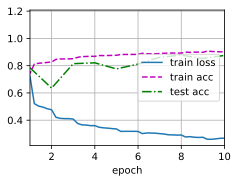

In [26]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

简明实现

loss 0.275, train acc 0.899, test acc 0.797
57828.5 examples/sec on cuda:0


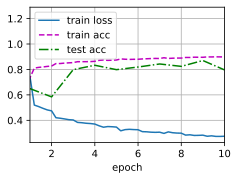

In [24]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())